# Change Log

[+] Rearranged and Cleaned <br> 

In [1]:
#from animalai.trainers.trainer_controller import TrainerController
from animalai.envs import UnityEnvironment
from animalai.envs.exception import UnityEnvironmentException
from animalai.envs.arena_config import ArenaConfig
import random
import yaml
import sys
import cv2
import os
import shutil
import pandas as pd
import _pickle as cPickle
import matplotlib.pyplot as plt

In [2]:
# Renovation WIP

#from collections import deque

import gym
import math
import numpy as np
import random
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Renovation WIP

# Functions

def remember(state, action, reward, next_state, done):
    
    memory.append((state, action, reward, next_state, done))
    
def choose_action(state, vectObs, epsilon):
    
    if np.random.random() <= epsilon:
        return random_action()
    else:
        return dict_action[np.argmax(model.predict([np.reshape(np.array(state), (1, 84, 84, 3)), np.expand_dims(np.array(vectObs), axis=0)]))]

def get_epsilon(t):
    
    return max(epsilon_min, min(epsilon, 1 - math.log10((t + 1) * epsilon_decay)))

def preprocess_state(state):
    
    return np.reshape(state, [1, 84, 84, 3])

def replay(batch_size):
    
    global epsilon
    
    x_batch, x_batch_secondary, y_batch = [], [], []
    
    random_idx = [random.randint(1, dump_counter - 1) for i in range(min(len(os.listdir('./Memory/')), batch_size))]
    
    mini_batch = prepare_mini_batch(random_idx)
    
    for state, vectObs, action, reward, next_state, next_vectObs, done in mini_batch:    # Secondary3
        y_target = model.predict([np.reshape(np.array(state), (1, 84, 84, 3)), np.expand_dims(np.array(vectObs), axis=0)])    # Fault Line
        y_target[0][action] = reward if done else reward + gamma * np.max(model.predict([next_state, np.expand_dims(np.array(next_vectObs), axis=0)])[0])
        x_batch.append(state[0]) # Because reshaped state will be used i.e [1, 4] dimensional
        x_batch_secondary.append(vectObs)
        y_batch.append(y_target[0])
        
    model.fit([np.array(x_batch), np.reshape(np.array(x_batch_secondary), (64, 6))], np.array(y_batch), batch_size=len(x_batch), verbose=0)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [4]:
def prepare_mini_batch(random_idx):
    
    mini_batch = []
    
    for i in random_idx:
        
        with open('./Memory/' + str(i) + '.pkl', 'rb') as f:
            mini_batch += [cPickle.load(f)]
            
    return mini_batch

In [5]:
# Training Params 

n_episodes = 1000
max_env_steps = None

gamma = 1.0 # Discount Factor
epsilon = 1.0 # Exploration
epsilon_min = 0.01
epsilon_decay = 0.995
alpha = 0.01 # Learning Rate
alpha_decay = 0.01

batch_size = 64
monitor = False

In [6]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from keras.applications import *


def partial_train_pretrained_model(dim=84, no_of_layer_to_be_freezed=116):

    weights = os.path.join('', 'weights.h5')

    epochs = 5
    learning_rate = 0.0001
    batch_size = 32

    callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
                  ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]
                  


    # Load any existing weights
    if os.path.isfile(weights):
         model.load_weights(weights)
    
    base_model = Xception(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
    x = base_model.output
    secondaryObs = Input(shape=(6, ))       # Secondary Vector Obs
    conc = Concatenate()([x, secondaryObs])
    x = Dense(1024, activation='relu')(conc)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(9, activation='softmax')(x)
    model = Model(inputs=[base_model.input, secondaryObs], outputs=predictions)
    
    # Freeze layers not in classifier due to loading imagenet weights
    for layer in base_model.layers[:no_of_layer_to_be_freezed]:
         layer.trainable = False


    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [7]:
model = partial_train_pretrained_model()

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 41, 41, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 41, 41, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 41, 41, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

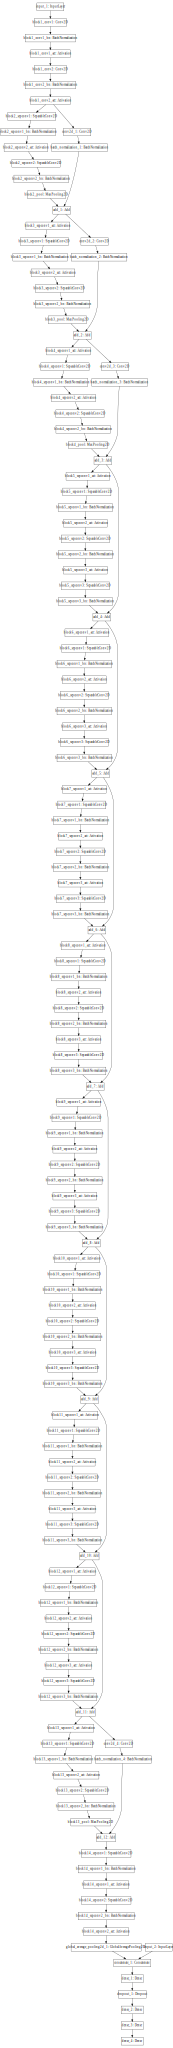

In [8]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

visualize_model(model)

In [9]:
def color_segmentation(image, objectColor, return_mask=False, show_image=True):

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if objectColor == 'green':

        low = (36, 25, 25)

        high = (70, 255,255)

    elif objectColor == 'red':

        low = (0, 100, 0)

        high = (5, 255, 255)

    elif objectColor == 'gold':

        low = (20, 140, 60)

        high = (22, 255, 255)

    else:

        print('Available Colors: green, red, gold')

    mask = cv2.inRange(hsv, low, high)      

    imask = mask > 0

    oneColored = np.zeros_like(image, np.uint8)

    oneColored[imask] = image[imask]
   

    if show_image:

        plt.imshow(bgr_to_rgb(oneColored))

        plt.show()

    if return_mask:

        return mask

In [10]:
def color_segmentation_flag_generator(image, show_image=False):

    df = pd.DataFrame()    

    if show_image:

        plt.imshow(bgr_to_rgb(oneColored))

        plt.show()

    for objectColor in ['green', 'red', 'gold'][:]:        

        mask = color_segmentation(image, objectColor, return_mask=True, show_image=False)

        df[objectColor] = [int(mask.sum()>0)]

        df['amount_' + objectColor] = [(mask.sum() / 255) / 21168]
        
      
    return df

In [11]:
env = UnityEnvironment(
                        file_name='D:\\AnimalAI\\AnimalAI-Olympics\\AnimalAI.exe',   # Path to the environment
                        worker_id=1,                # Unique ID for running the environment (used for connection)
                        seed=0,                     # The random seed 
                        docker_training=False,      # Whether or not you are training inside a docker
                        #no_graphics=False,         # Always set to False
                        n_arenas=1,                 # Number of arenas in your environment
                        play=False                  # Set to False for training                
                       )

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1


In [12]:
#env.close()

In [13]:
#amit
#define action dictionary
dict_action=dict()

#possible actions
action_updown=[0,1,2]
action_rightleft=[0,1,2]

#temporary variables
action_count=0

for temp_act_1 in action_updown:
    for temp_act_2 in action_rightleft:
        dict_action[action_count]=[temp_act_1,temp_act_2]
        action_count+=1
        
def get_action_index_from_vector(action_vector_):
    #make a list of action vectors and find index from it
    #print(action_vector_)
    action_index = list(dict_action.values()).index(action_vector_)
    return action_index

def get_state_reward_done(action_index):
    #update env with an action
    info = env.step(vector_action=dict_action[action_index])
    
    #get required information after updating env
    done_ = info['Learner'].local_done[0]
    reward_ = info['Learner'].rewards[0]
    next_state_ = info['Learner'].visual_observations[0].squeeze()
    
    kk2 = np.zeros((84, 84, 3), np.float32)

    for i in range(kk2.shape[0]):
        for j in range(kk2.shape[1]):
            for k in range(kk2.shape[2]):
                kk2[i][j][k] = np.float32(next_state_[i][j][k])
    
    #img = np.array(next_state_, dtype=np.uint8)
    next_vectObs_ = list(color_segmentation_flag_generator(kk2).values[0]) #info['Learner'].vector_observations     # Secondary
    
    return next_state_, next_vectObs_, reward_, done_

In [14]:
def random_action():
    
    action = random.sample(list(dict_action.values()), 1)[0]
    
    return action

In [15]:
dump_root = './Memory/'

if not os.path.exists(dump_root):
    os.mkdir(dump_root)

def generate_data_dump(package):
    
    global dump_counter
    
    with open(dump_root + str(dump_counter) + '.pkl', 'wb') as f:
        cPickle.dump(package, f)
        
    dump_counter += 1

dump_counter = 0

In [16]:
# Engine

import _pickle as cPickle

def run():
    
    for e in range(n_episodes):
        
        info = env.reset(arenas_configurations=arena)['Learner']
        
        state = preprocess_state(info.visual_observations[0].squeeze())
        
        kk = np.zeros((84, 84, 3), np.float32)

        for i in range(kk.shape[0]):
            for j in range(kk.shape[1]):
                for k in range(kk.shape[2]):
                    kk[i][j][k] = np.float32(state[0][i][j][k])
      
        vectObs = np.array(list(color_segmentation_flag_generator(kk).values[0])) #info.vector_observations   # Secondary
        done = False
        
        print('Running Episode: ', e)
        print('===================================')
        
        i = 0
        while not done:
            action = choose_action(state, vectObs, get_epsilon(e))     # Secondary
            #next_state, reward, done, _ = env.step(action)
            next_state, next_vectObs, reward, done = get_state_reward_done(get_action_index_from_vector(action)) # Secondary
            #env.render()
            next_state = preprocess_state(next_state)
            generate_data_dump([state, vectObs, action, reward, next_state, next_vectObs, done])  # MODDED   # Secondary!!!
            state = next_state
            vectObs = next_vectObs    # Secondary
            i += 1
        
        print('%d timesteps in Episode number %d' % (i, e))
        print('Reward:', reward)
        
        replay(batch_size)       # Secondary
        
    return e

In [17]:
arena = ArenaConfig('D:\\AnimalAI\\AnimalAI-Olympics\\examples\\configs\\exampleTraining.yaml')

In [18]:
run()
env.close()

if len(os.listdir(dump_root)) > 5:
    shutil.rmtree(dump_root)

dump_counter = 0

Running Episode:  0
1001 timesteps in Episode number 0
Reward: -0.0009999999310821295
Running Episode:  1
680 timesteps in Episode number 1
Reward: -1.6818690299987793
Running Episode:  2
1001 timesteps in Episode number 2
Reward: -0.0009999999310821295
Running Episode:  3
54 timesteps in Episode number 3
Reward: 0.7733170390129089
Running Episode:  4
197 timesteps in Episode number 4
Reward: 1.0983686447143555
Running Episode:  5
1001 timesteps in Episode number 5
Reward: -0.0009999999310821295
Running Episode:  6
20 timesteps in Episode number 6
Reward: -2.7585763931274414
Running Episode:  7
32 timesteps in Episode number 7
Reward: -4.613521099090576
Running Episode:  8
1 timesteps in Episode number 8
Reward: 1.3841629028320312
Running Episode:  9
1001 timesteps in Episode number 9
Reward: -0.0009999999310821295
Running Episode:  10
1001 timesteps in Episode number 10
Reward: -0.0009999999310821295
Running Episode:  11
1001 timesteps in Episode number 11
Reward: -0.00099999993108212

Running Episode:  67
1001 timesteps in Episode number 67
Reward: -0.0009999999310821295
Running Episode:  68
1001 timesteps in Episode number 68
Reward: -0.0009999999310821295
Running Episode:  69
1001 timesteps in Episode number 69
Reward: -0.0009999999310821295
Running Episode:  70
1001 timesteps in Episode number 70
Reward: -0.0009999999310821295
Running Episode:  71
1001 timesteps in Episode number 71
Reward: -0.0009999999310821295
Running Episode:  72
1001 timesteps in Episode number 72
Reward: -0.0009999999310821295
Running Episode:  73
1001 timesteps in Episode number 73
Reward: -0.0009999999310821295
Running Episode:  74
1001 timesteps in Episode number 74
Reward: -0.0009999999310821295
Running Episode:  75
1001 timesteps in Episode number 75
Reward: -0.0009999999310821295
Running Episode:  76
1001 timesteps in Episode number 76
Reward: -0.0009999999310821295
Running Episode:  77
1001 timesteps in Episode number 77
Reward: -0.0009999999310821295
Running Episode:  78
1001 timest

Running Episode:  133
1001 timesteps in Episode number 133
Reward: -0.0009999999310821295
Running Episode:  134
1001 timesteps in Episode number 134
Reward: -0.0009999999310821295
Running Episode:  135
1001 timesteps in Episode number 135
Reward: -0.0009999999310821295
Running Episode:  136
1001 timesteps in Episode number 136
Reward: -0.0009999999310821295
Running Episode:  137
1001 timesteps in Episode number 137
Reward: -0.0009999999310821295
Running Episode:  138
1001 timesteps in Episode number 138
Reward: -0.0009999999310821295
Running Episode:  139
1001 timesteps in Episode number 139
Reward: -0.0009999999310821295
Running Episode:  140
1001 timesteps in Episode number 140
Reward: -0.0009999999310821295
Running Episode:  141
1001 timesteps in Episode number 141
Reward: -0.0009999999310821295
Running Episode:  142
1001 timesteps in Episode number 142
Reward: -0.0009999999310821295
Running Episode:  143
1001 timesteps in Episode number 143
Reward: -0.0009999999310821295
Running Ep

1001 timesteps in Episode number 198
Reward: -0.0009999999310821295
Running Episode:  199
1001 timesteps in Episode number 199
Reward: -0.0009999999310821295
Running Episode:  200
1001 timesteps in Episode number 200
Reward: -0.0009999999310821295
Running Episode:  201
1001 timesteps in Episode number 201
Reward: -0.0009999999310821295
Running Episode:  202
1001 timesteps in Episode number 202
Reward: -0.0009999999310821295
Running Episode:  203
1001 timesteps in Episode number 203
Reward: -0.0009999999310821295
Running Episode:  204
1001 timesteps in Episode number 204
Reward: -0.0009999999310821295
Running Episode:  205
1001 timesteps in Episode number 205
Reward: -0.0009999999310821295
Running Episode:  206
1001 timesteps in Episode number 206
Reward: -0.0009999999310821295
Running Episode:  207
1001 timesteps in Episode number 207
Reward: -0.0009999999310821295
Running Episode:  208
1001 timesteps in Episode number 208
Reward: -0.0009999999310821295
Running Episode:  209
1001 times

Running Episode:  264
1001 timesteps in Episode number 264
Reward: -0.0009999999310821295
Running Episode:  265
1001 timesteps in Episode number 265
Reward: -0.0009999999310821295
Running Episode:  266
1001 timesteps in Episode number 266
Reward: -0.0009999999310821295
Running Episode:  267
1001 timesteps in Episode number 267
Reward: -0.0009999999310821295
Running Episode:  268
1001 timesteps in Episode number 268
Reward: -0.0009999999310821295
Running Episode:  269
1001 timesteps in Episode number 269
Reward: -0.0009999999310821295
Running Episode:  270
1001 timesteps in Episode number 270
Reward: -0.0009999999310821295
Running Episode:  271
1001 timesteps in Episode number 271
Reward: -0.0009999999310821295
Running Episode:  272
1001 timesteps in Episode number 272
Reward: -0.0009999999310821295
Running Episode:  273
1001 timesteps in Episode number 273
Reward: -0.0009999999310821295
Running Episode:  274
1001 timesteps in Episode number 274
Reward: -0.0009999999310821295
Running Ep

1001 timesteps in Episode number 329
Reward: -0.0009999999310821295
Running Episode:  330
1001 timesteps in Episode number 330
Reward: -0.0009999999310821295
Running Episode:  331
1001 timesteps in Episode number 331
Reward: -0.0009999999310821295
Running Episode:  332
1001 timesteps in Episode number 332
Reward: -0.0009999999310821295
Running Episode:  333
1001 timesteps in Episode number 333
Reward: -0.0009999999310821295
Running Episode:  334
1001 timesteps in Episode number 334
Reward: -0.0009999999310821295
Running Episode:  335
1001 timesteps in Episode number 335
Reward: -0.0009999999310821295
Running Episode:  336
1001 timesteps in Episode number 336
Reward: -0.0009999999310821295
Running Episode:  337
1001 timesteps in Episode number 337
Reward: -0.0009999999310821295
Running Episode:  338
1001 timesteps in Episode number 338
Reward: -0.0009999999310821295
Running Episode:  339
1001 timesteps in Episode number 339
Reward: -0.0009999999310821295
Running Episode:  340
1001 times

Running Episode:  395
1001 timesteps in Episode number 395
Reward: -0.0009999999310821295
Running Episode:  396
1001 timesteps in Episode number 396
Reward: -0.0009999999310821295
Running Episode:  397
1001 timesteps in Episode number 397
Reward: -0.0009999999310821295
Running Episode:  398
1001 timesteps in Episode number 398
Reward: -0.0009999999310821295
Running Episode:  399
1001 timesteps in Episode number 399
Reward: -0.0009999999310821295
Running Episode:  400
1001 timesteps in Episode number 400
Reward: -0.0009999999310821295
Running Episode:  401
1001 timesteps in Episode number 401
Reward: -0.0009999999310821295
Running Episode:  402
1001 timesteps in Episode number 402
Reward: -0.0009999999310821295
Running Episode:  403
1001 timesteps in Episode number 403
Reward: -0.0009999999310821295
Running Episode:  404
1001 timesteps in Episode number 404
Reward: -0.0009999999310821295
Running Episode:  405
1001 timesteps in Episode number 405
Reward: -0.0009999999310821295
Running Ep

Running Episode:  461
1001 timesteps in Episode number 461
Reward: -0.0009999999310821295
Running Episode:  462
1001 timesteps in Episode number 462
Reward: -0.0009999999310821295
Running Episode:  463
1001 timesteps in Episode number 463
Reward: -0.0009999999310821295
Running Episode:  464
1001 timesteps in Episode number 464
Reward: -0.0009999999310821295
Running Episode:  465
1001 timesteps in Episode number 465
Reward: -0.0009999999310821295
Running Episode:  466
1001 timesteps in Episode number 466
Reward: -0.0009999999310821295
Running Episode:  467
1001 timesteps in Episode number 467
Reward: -0.0009999999310821295
Running Episode:  468
1001 timesteps in Episode number 468
Reward: -0.0009999999310821295
Running Episode:  469
1001 timesteps in Episode number 469
Reward: -0.0009999999310821295
Running Episode:  470
1 timesteps in Episode number 470
Reward: 1.0838422775268555
Running Episode:  471
1001 timesteps in Episode number 471
Reward: -0.0009999999310821295
Running Episode: 

1001 timesteps in Episode number 526
Reward: -0.0009999999310821295
Running Episode:  527
1001 timesteps in Episode number 527
Reward: -0.0009999999310821295
Running Episode:  528
1001 timesteps in Episode number 528
Reward: -0.0009999999310821295
Running Episode:  529
1001 timesteps in Episode number 529
Reward: -0.0009999999310821295
Running Episode:  530
1001 timesteps in Episode number 530
Reward: -0.0009999999310821295
Running Episode:  531
1 timesteps in Episode number 531
Reward: -4.412703037261963
Running Episode:  532
1001 timesteps in Episode number 532
Reward: -0.0009999999310821295
Running Episode:  533
1001 timesteps in Episode number 533
Reward: -0.0009999999310821295
Running Episode:  534
1001 timesteps in Episode number 534
Reward: -0.0009999999310821295
Running Episode:  535
1001 timesteps in Episode number 535
Reward: -0.0009999999310821295
Running Episode:  536
1001 timesteps in Episode number 536
Reward: -0.0009999999310821295
Running Episode:  537
1001 timesteps in

Running Episode:  592
1001 timesteps in Episode number 592
Reward: -0.0009999999310821295
Running Episode:  593
1001 timesteps in Episode number 593
Reward: -0.0009999999310821295
Running Episode:  594
1001 timesteps in Episode number 594
Reward: -0.0009999999310821295
Running Episode:  595
1001 timesteps in Episode number 595
Reward: -0.0009999999310821295
Running Episode:  596
1001 timesteps in Episode number 596
Reward: -0.0009999999310821295
Running Episode:  597
1001 timesteps in Episode number 597
Reward: -0.0009999999310821295
Running Episode:  598
1001 timesteps in Episode number 598
Reward: -0.0009999999310821295
Running Episode:  599
1001 timesteps in Episode number 599
Reward: -0.0009999999310821295
Running Episode:  600
1001 timesteps in Episode number 600
Reward: -0.0009999999310821295
Running Episode:  601
1001 timesteps in Episode number 601
Reward: -0.0009999999310821295
Running Episode:  602
1001 timesteps in Episode number 602
Reward: -0.0009999999310821295
Running Ep

1001 timesteps in Episode number 657
Reward: -0.0009999999310821295
Running Episode:  658
1001 timesteps in Episode number 658
Reward: -0.0009999999310821295
Running Episode:  659
1001 timesteps in Episode number 659
Reward: -0.0009999999310821295
Running Episode:  660
1001 timesteps in Episode number 660
Reward: -0.0009999999310821295
Running Episode:  661
937 timesteps in Episode number 661
Reward: 3.5681328773498535
Running Episode:  662
1001 timesteps in Episode number 662
Reward: -0.0009999999310821295
Running Episode:  663
1001 timesteps in Episode number 663
Reward: -0.0009999999310821295
Running Episode:  664
1001 timesteps in Episode number 664
Reward: -0.0009999999310821295
Running Episode:  665
1001 timesteps in Episode number 665
Reward: -0.0009999999310821295
Running Episode:  666
1001 timesteps in Episode number 666
Reward: -0.0009999999310821295
Running Episode:  667
1001 timesteps in Episode number 667
Reward: -0.0009999999310821295
Running Episode:  668
1001 timesteps 

Running Episode:  723
1001 timesteps in Episode number 723
Reward: -0.0009999999310821295
Running Episode:  724
1001 timesteps in Episode number 724
Reward: -0.0009999999310821295
Running Episode:  725
1001 timesteps in Episode number 725
Reward: -0.0009999999310821295
Running Episode:  726
1001 timesteps in Episode number 726
Reward: -0.0009999999310821295
Running Episode:  727
1001 timesteps in Episode number 727
Reward: -0.0009999999310821295
Running Episode:  728
1 timesteps in Episode number 728
Reward: 0.8379572629928589
Running Episode:  729
1001 timesteps in Episode number 729
Reward: -0.0009999999310821295
Running Episode:  730
1001 timesteps in Episode number 730
Reward: -0.0009999999310821295
Running Episode:  731
1001 timesteps in Episode number 731
Reward: -0.0009999999310821295
Running Episode:  732
1001 timesteps in Episode number 732
Reward: -0.0009999999310821295
Running Episode:  733
1001 timesteps in Episode number 733
Reward: -0.0009999999310821295
Running Episode: 

1001 timesteps in Episode number 788
Reward: -0.0009999999310821295
Running Episode:  789
1001 timesteps in Episode number 789
Reward: -0.0009999999310821295
Running Episode:  790
1001 timesteps in Episode number 790
Reward: -0.0009999999310821295
Running Episode:  791
1001 timesteps in Episode number 791
Reward: -0.0009999999310821295
Running Episode:  792
1001 timesteps in Episode number 792
Reward: -0.0009999999310821295
Running Episode:  793
1001 timesteps in Episode number 793
Reward: -0.0009999999310821295
Running Episode:  794
1001 timesteps in Episode number 794
Reward: -0.0009999999310821295
Running Episode:  795
1001 timesteps in Episode number 795
Reward: -0.0009999999310821295
Running Episode:  796
1001 timesteps in Episode number 796
Reward: -0.0009999999310821295
Running Episode:  797
1001 timesteps in Episode number 797
Reward: -0.0009999999310821295
Running Episode:  798
1001 timesteps in Episode number 798
Reward: -0.0009999999310821295
Running Episode:  799
1001 times

Running Episode:  854
1001 timesteps in Episode number 854
Reward: -0.0009999999310821295
Running Episode:  855
1 timesteps in Episode number 855
Reward: -2.9028234481811523
Running Episode:  856
1001 timesteps in Episode number 856
Reward: -0.0009999999310821295
Running Episode:  857
1001 timesteps in Episode number 857
Reward: -0.0009999999310821295
Running Episode:  858
1001 timesteps in Episode number 858
Reward: -0.0009999999310821295
Running Episode:  859
1001 timesteps in Episode number 859
Reward: -0.0009999999310821295
Running Episode:  860
1001 timesteps in Episode number 860
Reward: -0.0009999999310821295
Running Episode:  861
1001 timesteps in Episode number 861
Reward: -0.0009999999310821295
Running Episode:  862
1001 timesteps in Episode number 862
Reward: -0.0009999999310821295
Running Episode:  863
1001 timesteps in Episode number 863
Reward: -0.0009999999310821295
Running Episode:  864
1001 timesteps in Episode number 864
Reward: -0.0009999999310821295
Running Episode:

1001 timesteps in Episode number 919
Reward: -0.0009999999310821295
Running Episode:  920
1001 timesteps in Episode number 920
Reward: -0.0009999999310821295
Running Episode:  921
1001 timesteps in Episode number 921
Reward: -0.0009999999310821295
Running Episode:  922
1001 timesteps in Episode number 922
Reward: -0.0009999999310821295
Running Episode:  923
1001 timesteps in Episode number 923
Reward: -0.0009999999310821295
Running Episode:  924
1001 timesteps in Episode number 924
Reward: -0.0009999999310821295
Running Episode:  925
1001 timesteps in Episode number 925
Reward: -0.0009999999310821295
Running Episode:  926
1001 timesteps in Episode number 926
Reward: -0.0009999999310821295
Running Episode:  927
1001 timesteps in Episode number 927
Reward: -0.0009999999310821295
Running Episode:  928
1001 timesteps in Episode number 928
Reward: -0.0009999999310821295
Running Episode:  929
1001 timesteps in Episode number 929
Reward: -0.0009999999310821295
Running Episode:  930
1001 times

Running Episode:  985
1001 timesteps in Episode number 985
Reward: -0.0009999999310821295
Running Episode:  986
1001 timesteps in Episode number 986
Reward: -0.0009999999310821295
Running Episode:  987
1001 timesteps in Episode number 987
Reward: -0.0009999999310821295
Running Episode:  988
1001 timesteps in Episode number 988
Reward: -0.0009999999310821295
Running Episode:  989
1001 timesteps in Episode number 989
Reward: -0.0009999999310821295
Running Episode:  990
1001 timesteps in Episode number 990
Reward: -0.0009999999310821295
Running Episode:  991
1001 timesteps in Episode number 991
Reward: -0.0009999999310821295
Running Episode:  992
1001 timesteps in Episode number 992
Reward: -0.0009999999310821295
Running Episode:  993
1001 timesteps in Episode number 993
Reward: -0.0009999999310821295
Running Episode:  994
1001 timesteps in Episode number 994
Reward: -0.0009999999310821295
Running Episode:  995
1001 timesteps in Episode number 995
Reward: -0.0009999999310821295
Running Ep

In [19]:
remove

# TEST

In [29]:
env.close()

In [24]:
env.brains['Learner']

In [28]:
env.reset(arena)

{'Learner': <animalai.envs.brain.BrainInfo at 0x23f27db8c88>}